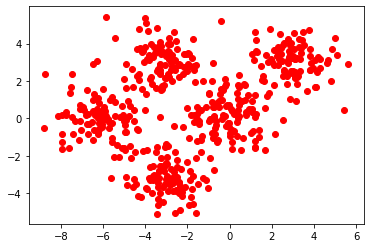

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans

n_clusters = 5
k=6

center = 3
dev = 1
n_points = 100
cluster = [None]*6

cluster[0] = np.random.normal(0, dev, (n_points,2))
cluster[1] = np.random.normal(center, dev, (n_points,2))
cluster[2] = np.random.normal(-center, dev, (n_points,2))
cluster[3] = np.concatenate((np.random.normal(-center, dev, (n_points,1)),np.random.normal(center, dev, (n_points,1))), axis=1)
cluster[4] = np.concatenate((np.random.normal(-2*center, dev, (n_points,1)),np.random.normal(0, dev, (n_points,1))), axis=1)
cluster[5] = np.concatenate((np.random.normal(center, dev, (n_points,1)),np.random.normal(-center, dev, (n_points,1))), axis=1)

X_train = cluster[0]
for i in range(1,n_clusters):
    X_train = np.concatenate((X_train,cluster[i]))

X_train = shuffle(X_train, random_state=0)

plt.scatter(X_train[:,0], X_train[:,1], c='red')

In [2]:
X_train.shape

(500, 2)

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F

device = torch.device("cpu")

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X_train):
        X = torch.from_numpy(X_train).float()
        X.requires_grad=True
        self.X = X.to(device)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index]
    
train_data = CustomDataset(X_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10*n_clusters)

class Net(nn.Module):

    def __init__(self, n_features):
        super(Net, self).__init__()
        #self.fc1 = nn.Linear(n_features, k, bias=True)
        #self.fc2 = nn.Linear(k, n_clusters, bias=True)
        self.model = nn.Sequential(
            nn.Linear(n_features, 10, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(10),
            
            nn.Linear(10, n_clusters, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(n_clusters),
        )

    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=1)
        return x

    #def forward(self, x):
        #x = nn.functional.relu(self.fc1(x))
        #return F.softmax(self.fc2(x))

net = Net(2)

net = net.to(device)

In [4]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))
    return s

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.5)
train_data = CustomDataset(X_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=int(n_points*n_clusters/1))

for epoch in range(100):
    for n, X in enumerate(train_loader):
        y = net(X)
        y = torch.squeeze(y)
        loss = 1 - soft_silhouette(X, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: {:d} Loss {:.4f}".format(epoch, loss))

Epoch: 0 Loss 1.0864
Epoch: 1 Loss 1.4361
Epoch: 2 Loss 1.5562
Epoch: 3 Loss 1.5168
Epoch: 4 Loss 1.3030
Epoch: 5 Loss 1.1338
Epoch: 6 Loss 1.0512
Epoch: 7 Loss 1.0739
Epoch: 8 Loss 1.0292
Epoch: 9 Loss 1.0298
Epoch: 10 Loss 0.9488
Epoch: 11 Loss 0.9457
Epoch: 12 Loss 0.9332
Epoch: 13 Loss 0.8972
Epoch: 14 Loss 0.8491
Epoch: 15 Loss 0.8166
Epoch: 16 Loss 0.7734
Epoch: 17 Loss 0.7580
Epoch: 18 Loss 0.7284
Epoch: 19 Loss 0.6657
Epoch: 20 Loss 0.6259
Epoch: 21 Loss 0.5841
Epoch: 22 Loss 0.5576
Epoch: 23 Loss 0.5305
Epoch: 24 Loss 0.5102
Epoch: 25 Loss 0.4974
Epoch: 26 Loss 0.4893
Epoch: 27 Loss 0.4819
Epoch: 28 Loss 0.4738
Epoch: 29 Loss 0.4661
Epoch: 30 Loss 0.4603
Epoch: 31 Loss 0.4569
Epoch: 32 Loss 0.4552
Epoch: 33 Loss 0.4546
Epoch: 34 Loss 0.4541
Epoch: 35 Loss 0.4531
Epoch: 36 Loss 0.4514
Epoch: 37 Loss 0.4492
Epoch: 38 Loss 0.4471
Epoch: 39 Loss 0.4452
Epoch: 40 Loss 0.4438
Epoch: 41 Loss 0.4427
Epoch: 42 Loss 0.4421
Epoch: 43 Loss 0.4419
Epoch: 44 Loss 0.4417
Epoch: 45 Loss 0.441

In [6]:
y_true = []
for x in X_train:
    for i in range(len(cluster)):
        if len(np.where(cluster[i] == x)[0])>0:
            y_true.append(i)

In [7]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

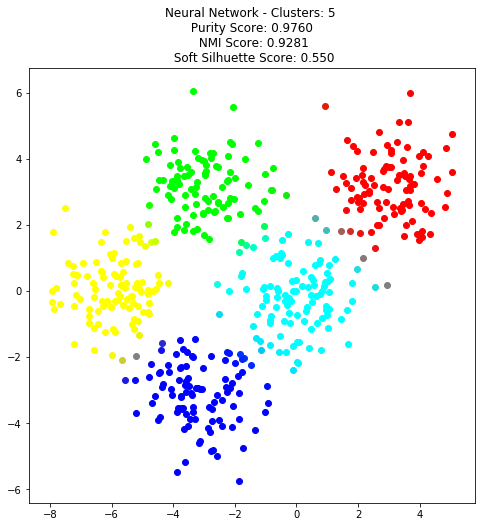

In [8]:
X = torch.from_numpy(X_train).float()
X.requires_grad=True
y = net(X)
s = soft_silhouette(X, y)
y = y.detach().numpy()
X = X.detach().numpy()

color1 = (0, 0, 1)
color2 = (0, 1, 0)
color3 = (1, 0 , 0)
color4 = (0, 1 , 1)
color5 = (1, 1, 0)
color6 = (1, 0, 1)
colors = [color1, color2, color3, color4, color5, color6, color1, color2, color3, color4, color5, color6]

plt.figure(figsize=(8, 8))
for i in range(y.shape[0]):
    color = [0, 0, 0]
    for j in range(y.shape[1]):
        color[0] = min(round(color[0] + y[i][j]*colors[j][0], 3), 1)
        color[1] = min(round(color[1] + y[i][j]*colors[j][1], 3), 1)
        color[2] = min(round(color[2] + y[i][j]*colors[j][2], 3), 1)
    color = tuple(color)
    plt.scatter(X[i,0], X[i,1], color=color)
plt.title(f'Neural Network - Clusters: {n_clusters} \n Purity Score: {purity_score(y_true, np.argmax(y, axis=-1)):.4f} \n NMI Score: {normalized_mutual_info_score(y_true, np.argmax(y, axis=-1)):.4f}\n Soft Silhuette Score: {s:.3f}')
#plt.show()
plt.savefig("/home/geo/Desktop/Soft-Silhouette/fig", facecolor="w")

In [8]:
X = torch.from_numpy(X_train).float()
X.requires_grad=True

gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(X_train)
probabilities = gm.predict_proba(X_train)
s = silhouette(X, torch.from_numpy(probabilities).float())
print(f'Mixture Model - Clusters: {n_clusters} \n Purity Score: {purity_score(y_true, np.argmax(probabilities, axis=-1))} \n Soft Silhouette Score: {s} \n NMI Score: {normalized_mutual_info_score(y_true, np.argmax(probabilities, axis=-1))}')


NameError: name 'silhouette' is not defined

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train)
print(f'Mixture Model - Clusters: {n_clusters} \n Purity Score: {purity_score(y_true, kmeans.labels_)}')
